# LSTM Tryout

Epochs: 15


Steps per Epoch: 1500 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow

import platform
import time
import pathlib
import os, glob

In [3]:
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [4]:
files = '../recipes_without_duplicates/converted/recipe_df_*.feather'
recipe_n = 100000
file_n = len(glob.glob(files))
recipes_per_files =  np.ceil(recipe_n/file_n).astype(int)
recipes_per_files

9091

Read all files, sample 100.000 recipes 

from each file x samples

In [5]:
recipe_df = pd.DataFrame()
for file in glob.glob(files):
    recipe_temp_df = pd.read_feather(file)
    if recipes_per_files > len(recipe_temp_df):
        samples = recipe_temp_df
    else:
        samples = recipe_temp_df.sample(recipes_per_files)
    recipe_df = pd.concat([recipe_df, samples])
recipe_df

recipe_np = recipe_df[['name', 'ingredients', 'instructions']].to_numpy()
recipe_np.shape

(93556, 3)

1. Preprocessing

changing df to numpy array and generating text with stop words

In [6]:
def recipe_to_string(recipe):
    ingredients = recipe[1]
    instructions = recipe[2].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient['amount'] + (" " if ingredient['unit'] != "" else "") + ingredient['name']
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [7]:
dataset_stringified = [recipe_to_string(recipe) for recipe in recipe_np]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  93556


In [8]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------

🥕

• 500 Kartoffel(n), festkochend
• 2 Zwiebel(n), gehackt
• 1 Senf
• 125 Brühe, heiß, ca. Salat sollte nicht schwimmen!
• 1 Muskat
• Salz
• Pfeffer
• Weißweinessig
• Öl

📝

▪︎ Kartoffeln in der Schale kochen, anschließend pellen.
▪︎ Noch warm in hauchdünne Scheiben schneiden, mit den Zwiebeln mischen. Anschließend die heiße Brühe hinzugeben mischen, Öl, Senf und Essig hinzugeben, mischen und mit Salz, Muskatnuss und Pfeffer abschmecken, noch warm essen.
▪︎ Man kann auch Gurken untermischen.



Recipe #2
---------

🥕

• 1 Pellkartoffel(n), vorwiegend festkochend
• 2 Senf, mittelscharfer
• 3 Zucker
• 100 Gurkenflüssigkeit
• 50 Weißweinessig
• 100 Distelöl oder Sonnenblumenöl
• 1Apfel, säuerlich
• 4 Gewürzgurke(n)
• 1 Zwiebel(n)
• 1 Knoblauch, nach Belieben
• ½ Frühlingszwiebel(n) oder Schnittlauch
• Salz und Pfeffer
• Kümmel

📝

▪︎ Die Kartoffeln mit 1 EL Salz und 1 EL Kümmel kochen. Abgießen, abschrecken, etwas abkühlen lassen und lauwarm pellen. 
▪︎ In der Zwische

2. Analysis of recipe length

Cut of all recipes with > 2500 

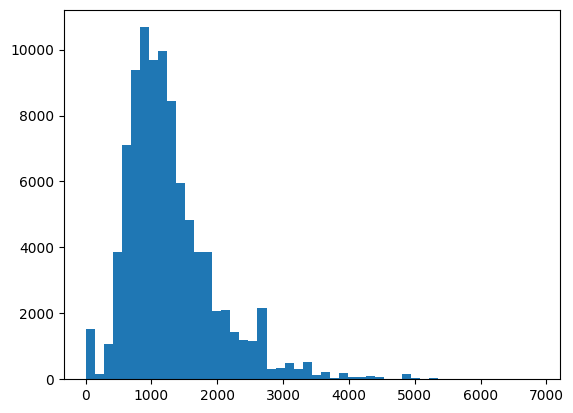

In [9]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

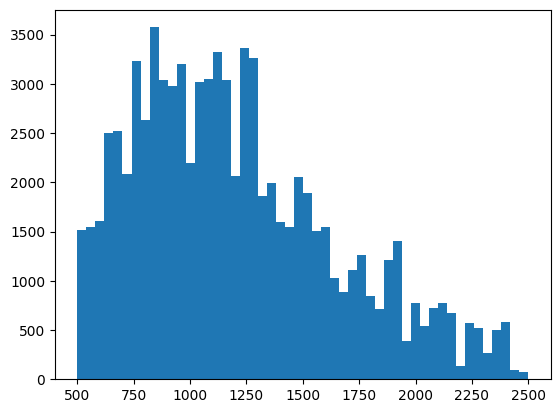

In [10]:
plt.hist(recipes_lengths, range=(500, 2500), bins=50)
plt.show()

In [11]:
MAX_RECIPE_LENGTH = 2500

In [12]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered)) 

Dataset size BEFORE filtering:  93556
Dataset size AFTER filtering:  87218
Number of eliminated recipes:  6338


In [13]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2500
TOTAL_RECIPES_NUM:  87218


3. Tokenizer

Seperate to single chars and then generating recepies again?!

In [14]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 87219,
 'word_counts': '{"\\u2423": 1, "\\n": 2055322, "\\ud83e\\udd55": 87218, "\\u2022": 1041067, " ": 14338959, "5": 248356, "0": 659899, "K": 399430, "a": 4261758, "r": 4662496, "t": 3908884, "o": 1731660, "f": 1773902, "e": 12319974, "l": 3423528, "(": 356070, "n": 8153597, ")": 355924, ",": 992070, "s": 3729153, "k": 1284468, "c": 2659976, "h": 2926783, "d": 2659182, "2": 405923, "Z": 285449, "w": 750140, "i": 5295567, "b": 1503743, "g": 1574256, "1": 551169, "S": 843499, "B": 407465, "\\u00fc": 846656, "\\u00df": 213495, ".": 1241234, "m": 1730513, "!": 19024, "M": 446084, "u": 2916158, "z": 1065266, "P": 431056, "W": 188635, "\\u00d6": 68937, "\\ud83d\\udcdd": 87218, "\\u25aa": 490947, "\\ufe0e": 490947, "p": 660038, "N": 77848, "A": 157943, "E": 219742, "G": 215894, "v": 424556, "3": 189942, "D": 348203, "\\u00f6": 274517, "\\u00e4": 339993, "4": 14617

In [15]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

print(tokenizer.index_word[5])
print(tokenizer.index_word[20])
tokenizer.word_index['r']

VOCABULARY_SIZE:  165
r
k


5

In [16]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', ' ', 'e', 'n', 'i', 'r', 'a', 't', 's', 'l', 'h', 'u', 'c', 'd', '\n', 'f', 'o', 'm', 'g', 'b', 'k', '.', 'z', '•', ',', 'ü', 'S', 'w', 'p', '0', '1', '▪', '︎', 'M', 'P', 'v', 'B', '2', 'K', '(', ')', 'D', 'ä', 'Z', 'ö', 'T', '5', 'E', 'G', 'ß', 'F', '3', 'W', 'R', 'H', '-', 'A', '4', 'O', 'L', 'C', '🥕', '📝', '\r', 'N', '6', 'I', 'Ö', '8', 'y', ':', 'V', 'j', '7', '½', 'J', '\u202f', '/', 'U', 'x', '°', '!', '9', 'q', '=', '"', 'à', 'Q', '–', 'è', 'î', 'é', '¼', 'Ä', 'Ü', '“', '%', '„', '̈', '&', '\t', '?', 'Ø', ';', '©', 'û', "'", 'ó', 'Y', '⅛', '’', '+', 'X', '⁄', '×', '\xad', '*', 'ê', '¾', 'á', 'ñ', 'ø', '®', '´', '‐', '»', '«', '#', '”', 'É', '…', '—', 'ı', '̀', 'ô', '`', '[', ']', '‚', 'ç', '_', '‘', '€', '|', 'í', '>', 'ú', 'â', '\u2009', 'º', 'ù', '⅓', '⁰', '́', '␣', '²', '<', '·', 'œ', 'ş', '\\', '~', '±', 'ã', '⅔']


In [17]:
tokenizer.texts_to_sequences(['🥕 yes'])

[[61, 1, 69, 2, 8]]

In [18]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized)) 

Vectorized dataset size 87218


In [19]:
print(dataset_vectorized[0][:10], '...') 

[14, 61, 14, 14, 23, 1, 46, 29, 29, 1] ...


In [20]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])


 🥕 
 
 •   5 0 0   K a r t o f f e l ( n ) ,   f e s t k o c h e n d 
 •   2   Z w i e b e l ( n ) ,   g e h a c k t 
 •   1   S e n f 
 •   1 2 5   B r ü h e ,   h e i ß ,   c a .   S a l a t   s o l l t e   n i c h t   s c h w i m m e n ! 
 •   1   M u s k a t 
 •   S a l z 
 •   P f e f f e r 
 •   W e i ß w e i n e s s i g 
 •   Ö l 
 
 📝 
 
 ▪ ︎   K a r t o f f e l n   i n   d e r   S c h a l e   k o c h e n ,   a n s c h l i e ß e n d   p e l l e n . 
 ▪ ︎   N o c h   w a r m   i n   h a u c h d ü n n e   S c h e i b e n   s c h n e i d e n ,   m i t   d e n   Z w i e b e l n   m i s c h e n .   A n s c h l i e ß e n d   d i e   h e i ß e   B r ü h e   h i n z u g e b e n   m i s c h e n ,   Ö l ,   S e n f   u n d   E s s i g   h i n z u g e b e n ,   m i s c h e n   u n d   m i t   S a l z ,   M u s k a t n u s s   u n d   P f e f f e r   a b s c h m e c k e n ,   n o c h   w a r m   e s s e n . 
 ▪ ︎   M a n   k a n n   a u c h   G u r k e n   u n t e r m i s c h e n . 



Checking length

In [21]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 498
Recipe #2 length: 1498
Recipe #3 length: 1539
Recipe #4 length: 1441
Recipe #5 length: 1382
Recipe #6 length: 1323
Recipe #7 length: 1611
Recipe #8 length: 1168
Recipe #9 length: 1453
Recipe #10 length: 1921


In [22]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2501
Recipe #1 length: 2501
Recipe #2 length: 2501
Recipe #3 length: 2501
Recipe #4 length: 2501
Recipe #5 length: 2501
Recipe #6 length: 2501
Recipe #7 length: 2501
Recipe #8 length: 2501
Recipe #9 length: 2501


In [23]:
recipe_sequence_to_string(dataset_vectorized_padded[0])


 🥕 
 
 •   5 0 0   K a r t o f f e l ( n ) ,   f e s t k o c h e n d 
 •   2   Z w i e b e l ( n ) ,   g e h a c k t 
 •   1   S e n f 
 •   1 2 5   B r ü h e ,   h e i ß ,   c a .   S a l a t   s o l l t e   n i c h t   s c h w i m m e n ! 
 •   1   M u s k a t 
 •   S a l z 
 •   P f e f f e r 
 •   W e i ß w e i n e s s i g 
 •   Ö l 
 
 📝 
 
 ▪ ︎   K a r t o f f e l n   i n   d e r   S c h a l e   k o c h e n ,   a n s c h l i e ß e n d   p e l l e n . 
 ▪ ︎   N o c h   w a r m   i n   h a u c h d ü n n e   S c h e i b e n   s c h n e i d e n ,   m i t   d e n   Z w i e b e l n   m i s c h e n .   A n s c h l i e ß e n d   d i e   h e i ß e   B r ü h e   h i n z u g e b e n   m i s c h e n ,   Ö l ,   S e n f   u n d   E s s i g   h i n z u g e b e n ,   m i s c h e n   u n d   m i t   S a l z ,   M u s k a t n u s s   u n d   P f e f f e r   a b s c h m e c k e n ,   n o c h   w a r m   e s s e n . 
 ▪ ︎   M a n   k a n n   a u c h   G u r k e n   u n t e r m i s c h e n . 
 ␣ ␣ 

In [24]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2501,), types: tf.int32>


2023-02-02 17:04:43.952478: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-02 17:04:43.958546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-02 17:04:44.111640: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 17:04:44.111803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 10.00GiB deviceMemoryBandwidth: 707.88GiB/s
2023-02-02 17:04:44.111828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-02 17:04:44.139308: I tensorflow/stream_executor/platfo

In [25]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

2023-02-02 17:08:42.339089: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 872528872 exceeds 10% of free system memory.


Raw recipe:
 [ 14  61  14 ... 154 154 154] 



Stringified recipe:


 🥕 
 
 •   5 0 0   K a r t o f f e l ( n ) ,   f e s t k o c h e n d 
 •   2   Z w i e b e l ( n ) ,   g e h a c k t 
 •   1   S e n f 
 •   1 2 5   B r ü h e ,   h e i ß ,   c a .   S a l a t   s o l l t e   n i c h t   s c h w i m m e n ! 
 •   1   M u s k a t 
 •   S a l z 
 •   P f e f f e r 
 •   W e i ß w e i n e s s i g 
 •   Ö l 
 
 📝 
 
 ▪ ︎   K a r t o f f e l n   i n   d e r   S c h a l e   k o c h e n ,   a n s c h l i e ß e n d   p e l l e n . 
 ▪ ︎   N o c h   w a r m   i n   h a u c h d ü n n e   S c h e i b e n   s c h n e i d e n ,   m i t   d e n   Z w i e b e l n   m i s c h e n .   A n s c h l i e ß e n d   d i e   h e i ß e   B r ü h e   h i n z u g e b e n   m i s c h e n ,   Ö l ,   S e n f   u n d   E s s i g   h i n z u g e b e n ,   m i s c h e n   u n d   m i t   S a l z ,   M u s k a t n u s s   u n d   P f e f f e r   a b s c h m e c k e n ,   n o c h   w a r m   e s s e n . 
 ▪ ︎   M a n 

Split into input and target

In [26]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text
dataset_targeted = dataset.map(split_input_target)
print(dataset_targeted)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
<MapDataset shapes: ((2500,), (2500,)), types: (tf.int32, tf.int32)>


Example datarow

In [27]:
for input_example, target_example in dataset_targeted.take(5):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

2023-02-02 17:08:52.914686: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 872528872 exceeds 10% of free system memory.
2023-02-02 17:08:53.109044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-02 17:08:53.110908: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393655000 Hz


Input sequence size: 2500
Target sequence size: 2500

Input:   '\n 🥕 \n \n •   5 0 0   K a r t o f f e l ( n ) ,   f e s t k o c h e n d \n •   2   Z w i e b e l ( n )'
Target:  '🥕 \n \n •   5 0 0   K a r t o f f e l ( n ) ,   f e s t k o c h e n d \n •   2   Z w i e b e l ( n ) ,'
Input sequence size: 2500
Target sequence size: 2500

Input:   '\n 🥕 \n \n •   1   P e l l k a r t o f f e l ( n ) ,   v o r w i e g e n d   f e s t k o c h e n d \n •'
Target:  '🥕 \n \n •   1   P e l l k a r t o f f e l ( n ) ,   v o r w i e g e n d   f e s t k o c h e n d \n •  '
Input sequence size: 2500
Target sequence size: 2500

Input:   '\n 🥕 \n \n •   2   K a r t o f f e l n ,   f e s t k o c h e n d e \n •   1 5 0   Z w i e b e l ( n ) \n'
Target:  '🥕 \n \n •   2   K a r t o f f e l n ,   f e s t k o c h e n d e \n •   1 5 0   Z w i e b e l ( n ) \n •'
Input sequence size: 2500
Target sequence size: 2500

Input:   '\n 🥕 \n \n •   2   K a r t o f f e l n ,   f e s t k o c h e n d e \n •   1   Z w i e

4. Training

Each index = step of RNN

In [28]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 14 ('\n')
  expected output: 61 ('🥕')
Step  2
  input: 61 ('🥕')
  expected output: 14 ('\n')
Step  3
  input: 14 ('\n')
  expected output: 14 ('\n')
Step  4
  input: 14 ('\n')
  expected output: 23 ('•')
Step  5
  input: 23 ('•')
  expected output: 1 (' ')
Step  6
  input: 1 (' ')
  expected output: 73 ('7')
Step  7
  input: 73 ('7')
  expected output: 46 ('5')
Step  8
  input: 46 ('5')
  expected output: 29 ('0')
Step  9
  input: 29 ('0')
  expected output: 1 (' ')
Step 10
  input: 1 (' ')
  expected output: 38 ('K')


In [29]:
print(dataset_targeted)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

<MapDataset shapes: ((2500,), (2500,)), types: (tf.int32, tf.int32)>
TOTAL_RECIPES_NUM:  87218
MAX_RECIPE_LENGTH:  2500
VOCABULARY_SIZE:  165


In [30]:
# Batch size.
BATCH_SIZE = 64
# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000
dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
print(dataset_train)

<RepeatDataset shapes: ((64, 2500), (64, 2500)), types: (tf.int32, tf.int32)>


In [31]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

2023-02-02 17:09:20.571715: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 872528872 exceeds 10% of free system memory.


1st batch: input_text: tf.Tensor(
[[ 14  61  14 ... 154 154 154]
 [ 14  61  14 ... 154 154 154]
 [ 14  61  14 ... 154 154 154]
 ...
 [ 14  61  14 ... 154 154 154]
 [ 14  61  14 ... 154 154 154]
 [ 14  61  14 ... 154 154 154]], shape=(64, 2500), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 61  14  14 ... 154 154 154]
 [ 61  14  14 ... 154 154 154]
 [ 61  14  14 ... 154 154 154]
 ...
 [ 61  14  14 ... 154 154 154]
 [ 61  14  14 ... 154 154 154]
 [ 61  14  14 ... 154 154 154]], shape=(64, 2500), dtype=int32)


6. Build a model

In [32]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2
tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)
print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[7 8 7 7 0 3 8 7]
 [3 2 1 1 3 5 2 5]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.03047417  0.02662181  0.01501154  0.03730377 -0.02352183]
  [ 0.00582689  0.04673951  0.03295496  0.02417353  0.02493599]
  [-0.03047417  0.02662181  0.01501154  0.03730377 -0.02352183]
  [-0.03047417  0.02662181  0.01501154  0.03730377 -0.02352183]
  [ 0.02153763  0.03671408 -0.04843073 -0.03397845 -0.00711749]
  [ 0.00233226 -0.00720821  0.04104025 -0.01344289  0.04275528]
  [ 0.00582689  0.04673951  0.03295496  0.02417353  0.02493599]
  [-0.03047417  0.02662181  0.01501154  0.03730377 -0.02352183]]

 [[ 0.00233226 -0.00720821  0.04104025 -0.01344289  0.04275528]
  [ 0.0323405   0.01174987 -0.04556755  0.02222158  0.00168554]
  [ 0.00160138  0.00598262 -0.01021992  0.02929473 -0.00818039]
  [ 0.00160138  0.00598262 -0.01021992  0.02929473 -0.00818039]
  [ 0.00233226 -0.00720821  0.04104025 -0.01344289  0.04275528]
  [-0.04647241  0.04106757 

In [33]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model
model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           42240     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 165)           169125    
Total params: 5,458,341
Trainable params: 5,458,341
Non-trainable params: 0
_________________________________________________________________


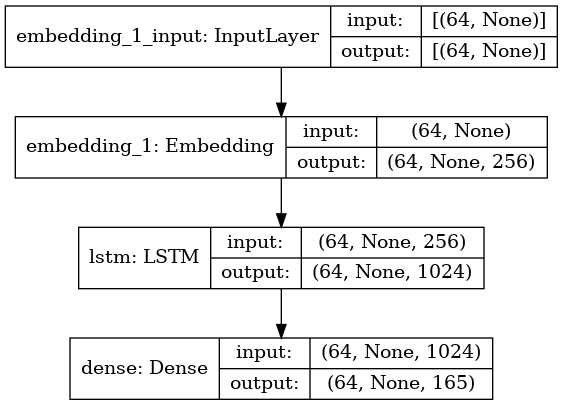

In [34]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

7. Start training

In [35]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

2023-02-02 17:09:47.379595: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 872528872 exceeds 10% of free system memory.
2023-02-02 17:09:47.834637: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-02-02 17:14:42.519556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(64, 2500, 165) # (batch_size, sequence_length, vocab_size)


Sampling

In [36]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-2.1780592e-03 -5.5876663e-03  5.5093835e-03 -2.7074635e-03
 -6.9554602e-03 -5.7184673e-03  4.4707436e-04  1.6673186e-03
 -2.3163022e-03  3.4852824e-03 -1.5497103e-03 -4.3451460e-04
  8.8970261e-03  6.4970218e-03  4.2517176e-03 -5.7475516e-03
  5.0240392e-03  4.7768131e-03  1.0169928e-03 -3.4324391e-04
 -6.2650384e-04  5.0383835e-04 -6.2372355e-04  1.4654084e-03
 -2.2873932e-03 -2.4461853e-03  8.1122359e-03  1.9692613e-03
  1.6697345e-03  2.1239030e-03 -1.2026584e-03 -2.1633147e-03
 -1.2873308e-03  6.0067774e-04 -7.2846154e-04  3.0729647e-03
 -3.1703038e-03  2.8768622e-03  6.2183954e-04  2.3093661e-03
 -2.0060802e-04 -5.3515881e-03 -3.9003512e-03 -1.9221964e-04
 -1.2738868e-03 -3.9834529e-04  9.3438791e-04  1.4376038e-03
 -3.4663400e-03 -2.7120643e-04 -2.3858161e-03 -7.0779556e-03
  7.4588245e-04  1.2970428e-03 -4.7204635e-04 -3.6134606e-03
  2.7497846e-03  2.7865556e-03 -1.0110630e-03 -6.4619433e-04
  1.8022278e-03  

In [37]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()
sampled_indices.shape

(2500,)

In [38]:
sampled_indices[:100]

array([151,  14, 123,  57,  89, 142,  39, 161, 148, 135, 117, 109, 163,
        34, 102,  38,  99,  12, 157,   2,  18,  28, 137,  11, 119, 130,
        39, 104,  50,  52,  87,  48,  17,  69,  94,  68,  63, 114,  37,
       104,  11, 158,  20,  99,  75,  96, 134,  56,  30,  23,  76, 129,
        82,  68,  83,  14, 125,  69, 104,  30,  45, 158,  59, 115,  69,
       157,   1,  72, 101,  24,  24, 104,  58, 107,  47, 103,  13, 147,
        35,  10,  60, 155,  77, 101,  68,  47, 163, 160,  91,  57,  20,
        78, 157, 146, 107,  25,  83,  79,   5,  34])

Checking for completion of recipe: not working yet!!!

In [39]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '\n 🥕 \n \n •   1   K a r t o f f e l ( n ) \n •   2 S a l a t g u r k e ( n ) \n •   3 E i ( e r ) ,   h'

Next char prediction:
 '⅓ \n ´ 4 è € ( ~ \u2009 ` ê ⅛ ã P Ø K & c · e g p ] u á … ( © F W Q G m y Ü 8 \r × 2 © u œ k & J % ô A 1 •'


In [40]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy
example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2500, 165)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2500)
scalar_loss:       5.1152616


In [41]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [42]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [43]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints_our_data_samples'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Launching training

In [44]:
EPOCHS = 12
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1000

In [45]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)
# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/12
1000/1000 [==============================] - 2767s 3s/step - loss: 1.1177
Epoch 3/12
1000/1000 [==============================] - 2908s 3s/step - loss: 0.3914
Epoch 4/12
1000/1000 [==============================] - 2822s 3s/step - loss: 0.3719
Epoch 5/12
1000/1000 [==============================] - 2772s 3s/step - loss: 0.3123
Epoch 6/12
1000/1000 [==============================] - 2743s 3s/step - loss: 0.2614
Epoch 7/12
1000/1000 [==============================] - 2686s 3s/step - loss: 0.1950
Epoch 8/12
1000/1000 [==============================] - 2778s 3s/step - loss: 0.1519
Epoch 9/12
1000/1000 [==============================] - 2894s 3s/step - loss: 0.1605
Epoch 10/12
1000/1000 [==============================] - 2825s 3s/step - loss: 0.1418
Epoch 11/12
1000/1000 [==============================] - 2736s 3s/step - loss: 0.1022
Epoch 12/12
1000/1000 [==============================] - 2686s 3s/step - loss: 0.1104


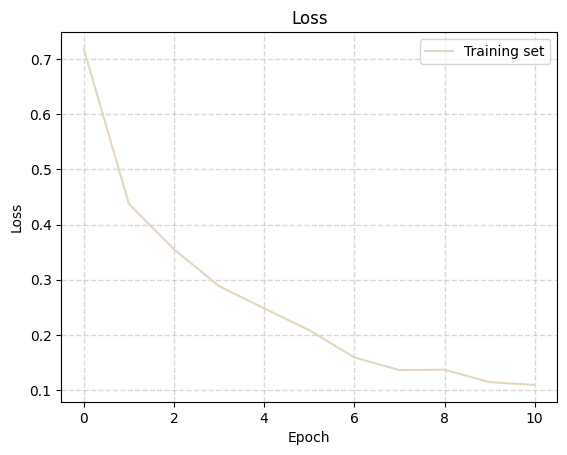

In [54]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set', color="#e2d6bf")
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

8. Restoring model from latest checkpoint

In [47]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints_our_data_samples/ckpt_12'

In [77]:
simplified_batch_size = 1
model_simplified = build_model(VOCABULARY_SIZE, 256, 1024, simplified_batch_size)
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))
model_simplified.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            42240     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_3 (Dense)              (1, None, 165)            169125    
Total params: 5,458,341
Trainable params: 5,458,341
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_simplified.input_shape

(1, None)

9. Predicting new recipes:

try out for input

In [72]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    padded_start_string = STOP_WORD_INGREDIENTS + start_string
    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))
    print(input_indices.shape)
    # Empty string to store our results.
    text_generated = []
    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()
        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]
        text_generated.append(next_character)
    return (padded_start_string + ''.join(text_generated))

In [73]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['Sonnenblumenöl', '• 1 EL Sonneblumenöl\n• eine große Zwiebel\n']
    try_temperature = [1.0, 0.8, 0.4, 0.2]
    output = ""
    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length + len(letter),
                temperature=temperature
            )
            output += f'Attempt: "{letter}" + {temperature}'
            output += '-----------------------------------'
            output += generated_text
            output += '\n\n'
    return output

Tryout mit Evaluation Ingredient list

In [82]:
try_ing = '• 1 EL Sonneblumenöl\n• eine große Zwiebel\n'
# • 1 Bund Karotten\n• 1 Karfiol\n• 1 Broccoli\n• 250 g Fisolen\n• 250 g geräucherter Tofu\n• 1 CHinakohl\n• 1 TL Sojasauce
len(try_ing)

42

In [83]:
recipe_length = 1000 + len(try_ing)

try_temperature = [1.0, 0.8, 0.4, 0.2]
output = ""

for temperature in try_temperature:
    generated_text = generate_text(
        model,
        start_string=try_ing,
        num_generate = recipe_length,
        temperature=temperature
    )
    output += f'Attempt: "{try_ing}" + {temperature}'
    output += '-----------------------------------'
    output += generated_text
    output += '\n\n'
txt = open('results/recipe_generated04_new.txt','w')
txt.write(output)
txt.close()

(1, 46)


ValueError: Input 0 is incompatible with layer lstm: expected shape=(64, None, 256), found shape=(1, 46, 256)

In [79]:
txt = open('results/recipe_generated04_new.txt','w')
txt.write(generate_combinations(model_simplified))
txt.close()

(1, 18)
(1, 18)
(1, 18)
(1, 18)
(1, 17)
(1, 17)
(1, 17)
(1, 17)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 12)
(1, 12)
(1, 12)
(1, 12)
(1, 21)
(1, 21)
(1, 21)
(1, 21)
(1, 13)
(1, 13)
(1, 13)
(1, 13)
(1, 13)
(1, 13)
(1, 13)
(1, 13)
